# CS 109 Contest : Predicting Pandemic
_By Maisam Pyarali_

### Background:

You wake up one morning with a scratchy throat and a runny nose. Back in high school, you might have stayed home with a cold, but these days you’re too busy to stay indoors and rest up; you have classes to attend, friends to meet, and extracurricular groups to lead. So you blow your nose, pop an Advil, and begin your day. 

Consider all of the people you come in close contact with that day. Within fifteen minutes of waking, you give your roommate back her calculator which you’ve borrowed for a midterm (1). CS109 doesn’t start until 10:30, so you grab breakfast with a few friends before class (3). You arrive to CS109 two minutes late and grab a seat next to your go-to study buddies who lived in your freshman dorm (2). After CS109, you have a lunch meeting for a club with all the executive members (6). You attend your afternoon lectures back-to-back (4). After a quick dinner (2) and a run to office hours (4), you decide to take a break and play a round of Super Smash bros with some friends down the hall (3). In all, you’ve spent time with 25 friends. 

Remember that sore throat you had in the morning? Turns out it’s an unseen strain of the flu virus, for which no vaccine has been prepared. It infects 90% of people who are closely exposed to an infected individual. 

But you don’t know this, and neither do your friends. So you all wake up the next morning with a scratchy throat and go about your days, infecting the next round of victims.



### Description:

We often take for granted how big a role herd immunity plays in our communities. This model shows the impact that a disease can have on the Stanford campus, and how it would spread. My model is designed for Stanford, but could be adjusted to cover larger regions in an effort to advance epidemiology and disease prevention worldwide. 

All the key numbers used in the model were supplied by a survey I conducted of student behaviour on campus.

The model has 3 key parts:

1. Calculating the average number of friends each person has based on where they live on campus
2. Calculating the number of third degree connections that a person has based on their location (Number of friends each friend has)
3. Generating infected patients and updating the model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

## 1. Number of Friends

Using a survey I sent out to random students, I found distributions of the number of friends each person has, conditional on where they live, using bootstrapping. Assuming responses to survey were random and a good representation of the Stanford population

In [2]:
df = pd.read_csv("behaviour.csv")

# Number of friends a person has given they live in a certain residence
# r = residential hall
# f = frat / sorority
# h = Other houses (row, co-ops, meriless)

resHall = df[(df.residence == "r")] 
fratSor = df[(df.residence == "f")]
otherHouses = df[(df.residence == "h")]

In [3]:
# Useful function
# Function that samples the responses 10000 times and returns a graph of the resulting list of means
# list - The list in question
# num - Number of samples to take each time

def bootstrapPlot(list = [], num =0): 
    meanList = []
    for i in range(10000):
        samples = np.random.choice(list, num, replace = True)
        meanList.append(np.mean(samples))

    %matplotlib inline
    plt.hist(meanList, bins = 100)
    print('Mean = ', round(np.mean(meanList)))
    print ('Var = ', round(np.var(meanList),2))
    
    return plt
    # Mean is safe to use since it is normally distributed

In [4]:
rFriends = resHall["friends"].values
fFriends = fratSor["friends"].values
hFriends = otherHouses["friends"].values

('Mean = ', 18.0)
('Var = ', 8.42)


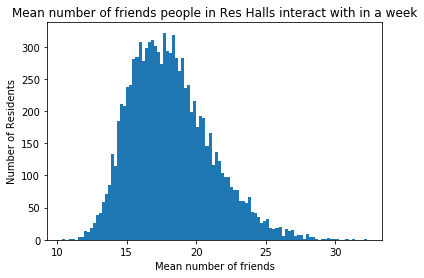

In [5]:
# Residence Halls:

plt = bootstrapPlot(list = rFriends, num = 53)
plt.ylabel('Number of Residents')
plt.xlabel('Mean number of friends')
plt.title('Mean number of friends people in Res Halls interact with in a week')
plt.show()

('Mean = ', 14.0)
('Var = ', 1.62)


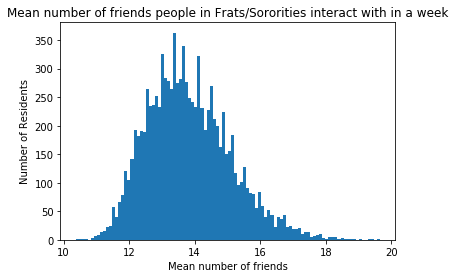

In [6]:
# Frats & Sororities:

plt = bootstrapPlot(list = fFriends, num = 35)
plt.ylabel('Number of Residents')
plt.xlabel('Mean number of friends')
plt.title('Mean number of friends people in Frats/Sororities interact with in a week')
plt.show()

('Mean = ', 17.0)
('Var = ', 23.57)


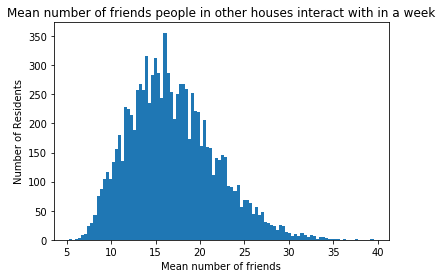

In [7]:
# Other Houses:

plt = bootstrapPlot(list = hFriends, num = 11)
plt.ylabel('Number of Residents')
plt.xlabel('Mean number of friends')
plt.title('Mean number of friends people in other houses interact with in a week')
plt.show()

## 2. Conditional Probabilities:

Once we know how many friends each person has, how do we find out where their friends live, conditional on where they live?

This can be found using conditional probabilities:

\begin{equation*}
P(res = q | parentRes = p)   = \frac{P(res = q, parentRes = p)} {P(parentRes = q)}
\end{equation*}

Where q and p can be residence hall, house, or fraternity/sorority.

In [8]:
resHall.sum()

# P(res = r | parentRes = r) = 578/963 = 0.6

residence    rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr...
friends                                                    963
parties                                                    206
sameAsYou                                                  578
dtype: object

In [9]:
fratSor.sum()

# P(res = f | parentRes = f) = 386/484 = 0.79

residence    fffffffffffffffffffffffffffffffffff
friends                                      484
parties                                      300
sameAsYou                                    386
dtype: object

In [10]:
otherHouses.sum()

# P(res = h | parentRes = h) = 133/186 = 0.72

residence    hhhhhhhhhhh
friends              186
parties               44
sameAsYou            133
dtype: object

## 3. Estimating spread of disease:

The user enters where patient zero lives and the transmission rate of the diseases, then the magic happens.

The underlying code generates a number of points that equals the number of friends each person has based on where they live. The number of friends is generated from a normal distribution with the parameters calculated in part 1. A random number of those friends are then classified as infected based on the transmission rate of the disease. This is done using a Bernoulli that randomly assigns a friend as infected with probability equal to the transmission rate.

Deciding how many friends the next round of infected individuals have is done using the livingSituation function. It uses a Bernoulli with probability calculated in part 2 and information from the Stanford RD&E website to calculate the most likely housing situation of each first degree connection.

Lastly, all the infected people are plotted on a scatter plot relative to the origin (patient zero). Then the Gaussian Kernel Density estimation shows the spread of the disease with data from the Stanford campus, updated at weekly intervals.

The Gaussian Kernal Density Estimation shows a distribution of the likelyhood of people being infected at each point on the map. 

Key Assumptions:

1. Disease can only spread from friend to friend
2. No one in the population is vaccinated

In [13]:
# Useful Function

import random
import math

# Bernoulli distribution with P(1) = p
def Bern(p = 0):
    if random.random() <= p:
        return 1
    else:
        return 0

In [14]:
# Generates living situation of new infected people based on calculations carried out in 2
# parentRes = Where the parent lived

def livingSituation (parentRes = 'f'):
    if parentRes == 'f':
        if Bern(p = 0.79) == 1:
            return 'f'
        elif Bern(p = 0.71) == 1: # This number was found on stanford RD&E website
            return 'r'
        else:
            return 'h'
        
    elif parentRes == 'r':
        if Bern(p = 0.6) == 1:
            return 'r'
        elif Bern(p = 0.27) == 1: # This number was found on stanford RD&E website
            return 'f'
        else:
            return 'h'
        
    elif parentRes == 'h':
        if Bern(p = 0.72) == 1:
            return 'h'
        elif Bern(p = 0.13) == 1: # This number was found on stanford RD&E website
            return 'f'
        else:
            return 'r'

# Genreates new infected friends based on location of person, where they live and disease transmission rate
# res = Where they live
# ro = Disease transmission rate
# xpt = x location of infected
# ypt = y location of infected

def generateNewPoints(res = 'f', ro = 0.5, xpt = 0, ypt = 0):
    x = []
    y = []
    newHome = []
    if res == 'f':
        friends = random.gauss(14, math.sqrt(2)) # Found from part 1
    elif res == 'r':
        friends = random.gauss(18, math.sqrt(8.34))
    else:
        friends = random.gauss(17, math.sqrt(23.3))
    
    for i in range(int(friends)):
        xVal = random.gauss(xpt, 1)
        yVal = random.gauss(ypt, 1)
        if Bern (p = ro) == 1:
            x.append(xVal)
            y.append(yVal)
            
    for j in range(len(x)):
        newHome.append(livingSituation(parentRes = res))        
   
    return x,y,newHome

# Appends values from one list to the other
# a = list from
# b = list to
def appendList(a = [], b = []):
    for value in a:
        b.append(value)
    return b


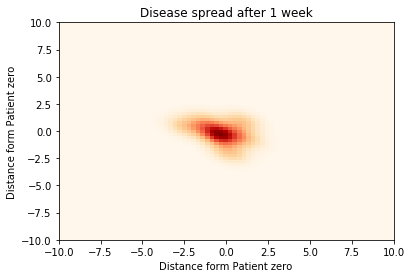

In [15]:
from scipy.stats import kde
import matplotlib as mpl

infectedX = [0]
infectedY = [0]
housing = ['f']
tr = 0.5


newInfectedX = []
newInfectedY = []
newHousing = []
for i in range (len(infectedX)):
    x, y, newHome = generateNewPoints(res = housing[i], ro = tr, xpt = infectedX[i], ypt = infectedY[i])
    newInfectedX = appendList(a = x, b = newInfectedX)
    newInfectedY = appendList(a = y, b = newInfectedY)
    newHousing = appendList(a = newHome, b = newHousing)
    
infectedX = appendList(a = newInfectedX, b = infectedX)
infectedY = appendList(a = newInfectedY, b = infectedY)
housing = appendList(a = newHousing, b = housing)

 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=74
k = kde.gaussian_kde([infectedX,infectedY])
xi, yi = np.mgrid[-10:10:nbins*1j, -10:10:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.OrRd)
plt.xlabel('Distance form Patient zero')
plt.ylabel('Distance form Patient zero')
plt.title('Disease spread after 1 week')
plt.show()

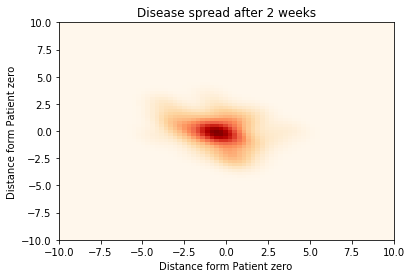

In [16]:
newInfectedX = []
newInfectedY = []
newHousing = []
for i in range (len(infectedX)):
    x, y, newHome = generateNewPoints(res = housing[i], ro = tr, xpt = infectedX[i], ypt = infectedY[i])
    newInfectedX = appendList(a = x, b = newInfectedX)
    newInfectedY = appendList(a = y, b = newInfectedY)
    newHousing = appendList(a = newHome, b = newHousing)
    
infectedX = appendList(a = newInfectedX, b = infectedX)
infectedY = appendList(a = newInfectedY, b = infectedY)
housing = appendList(a = newHousing, b = housing)

 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=74
k = kde.gaussian_kde([infectedX,infectedY])
xi, yi = np.mgrid[-10:10:nbins*1j, -10:10:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.OrRd)
plt.xlabel('Distance form Patient zero')
plt.ylabel('Distance form Patient zero')
plt.title('Disease spread after 2 weeks')
plt.show()

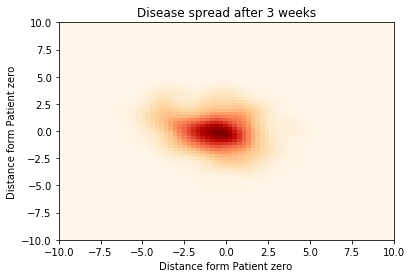

In [17]:
newInfectedX = []
newInfectedY = []
newHousing = []
for i in range (len(infectedX)):
    x, y, newHome = generateNewPoints(res = housing[i], ro = tr, xpt = infectedX[i], ypt = infectedY[i])
    newInfectedX = appendList(a = x, b = newInfectedX)
    newInfectedY = appendList(a = y, b = newInfectedY)
    newHousing = appendList(a = newHome, b = newHousing)
    
infectedX = appendList(a = newInfectedX, b = infectedX)
infectedY = appendList(a = newInfectedY, b = infectedY)
housing = appendList(a = newHousing, b = housing)

 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=74
k = kde.gaussian_kde([infectedX,infectedY])
xi, yi = np.mgrid[-10:10:nbins*1j, -10:10:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.OrRd)
plt.xlabel('Distance form Patient zero')
plt.ylabel('Distance form Patient zero')
plt.title('Disease spread after 3 weeks')
plt.show()

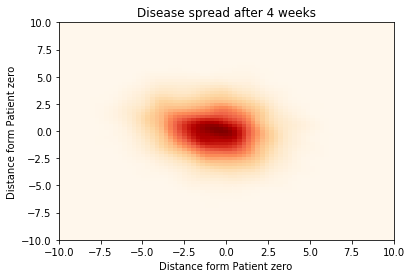

In [18]:
newInfectedX = []
newInfectedY = []
newHousing = []
for i in range (len(infectedX)):
    x, y, newHome = generateNewPoints(res = housing[i], ro = tr, xpt = infectedX[i], ypt = infectedY[i])
    newInfectedX = appendList(a = x, b = newInfectedX)
    newInfectedY = appendList(a = y, b = newInfectedY)
    newHousing = appendList(a = newHome, b = newHousing)
    
infectedX = appendList(a = newInfectedX, b = infectedX)
infectedY = appendList(a = newInfectedY, b = infectedY)
housing = appendList(a = newHousing, b = housing)

 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=74
k = kde.gaussian_kde([infectedX,infectedY])
xi, yi = np.mgrid[-10:10:nbins*1j, -10:10:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.OrRd)
plt.xlabel('Distance form Patient zero')
plt.ylabel('Distance form Patient zero')
plt.title('Disease spread after 4 weeks')
plt.show()